In [1]:
import ahoi
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
ahoi.tqdm = tqdm # use notebook progress bars in ahoi
import matplotlib.pyplot as plt
import math

# Kaggle Higgs challenge - cut based optimization with `ahoi`
The Data is available from the [CERN Open Data Portal](http://opendata.cern.ch/record/328)

In [2]:
import urllib
filename = "/tmp/atlas-higgs-challenge-2014-v2.csv.gz"
if not os.path.exists(filename):
    urllib.request.urlretrieve(
        "http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz",
        filename=filename
    )
df = pd.read_csv(filename)

In [3]:
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


We will only use the "derived quantities"

In [4]:
der_columns = [col for col in df.columns if "DER" in col]

In [5]:
der_columns

['DER_mass_MMC',
 'DER_mass_transverse_met_lep',
 'DER_mass_vis',
 'DER_pt_h',
 'DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_deltar_tau_lep',
 'DER_pt_tot',
 'DER_sum_pt',
 'DER_pt_ratio_lep_tau',
 'DER_met_phi_centrality',
 'DER_lep_eta_centrality']

Lets plot their distributions to find a reasonable set of cuts to scan

In [6]:
def plot_var(df, col, mask, ax):
    var = df[col]
    label = df.Label
    var = var[mask]
    label = label[mask]
    weights = df.KaggleWeight[mask]
    hist_range = np.quantile(var, [0.01, 0.99]) # plot in 1-99% range
    opts = dict(alpha=0.5, density=True, bins=100, range=hist_range)
    ax.hist(var[label=="b"], weights=weights[label=="b"], **opts)
    ax.hist(var[label=="s"], weights=weights[label=="s"], **opts)
    ax.set_xlabel(col)

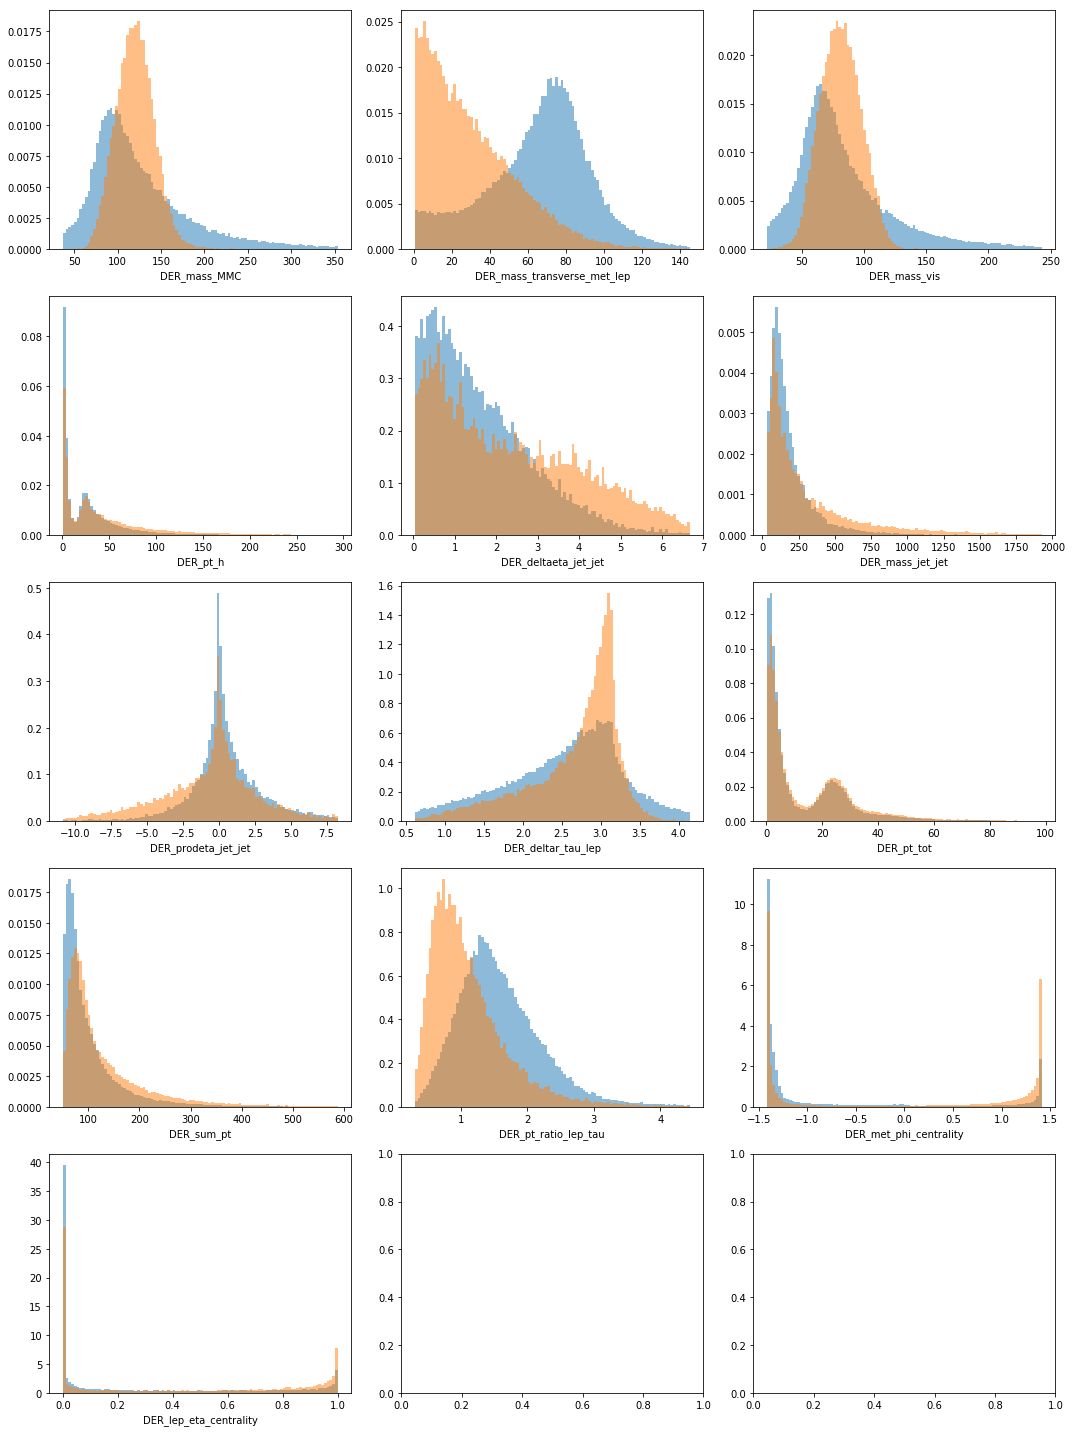

In [7]:
nrows = math.ceil(len(der_columns) / 3.)
fig, axs = plt.subplots(figsize=(15, 4 * nrows), nrows=nrows, ncols=3)
for col, ax in zip(der_columns, np.array(axs).ravel()):
    plot_var(df, col, df[col] != -999, ax)
fig.tight_layout()

## Define the cuts
Now define a range of cuts to scan, some lower bounds and some upper bounds. For some variables it makes sense to scan both upper and lower bounds. The strings are meant to put into [`DataFrame.eval`](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.eval.html?highlight=eval#pandas.DataFrame.eval). Feel free to experiment with this. We order all cuts such that the requirement which passes most events comes first. This is not strictly necessary (the "histogramdd" method in `ahoi` allows both increasing and decreasing selections), but helps since we want to add one cut that passes all events for each variable later that should be the first one.

In [8]:
ncuts = 3 # number of cuts to check per variable
cuts = [
    ("DER_mass_MMC > {}", list(np.linspace(75, 120, ncuts, dtype=int))),
    ("DER_mass_MMC < {}", list(np.linspace(175, 140, ncuts, dtype=int))),
    ("DER_mass_transverse_met_lep < {}", list(np.linspace(60, 20, ncuts, dtype=int))),
    ("DER_deltaeta_jet_jet > {}", list(np.round(np.linspace(2, 5, ncuts), 2))),
    ("DER_mass_jet_jet > {}", list(np.linspace(150, 500, ncuts, dtype=int))),
    ("DER_prodeta_jet_jet < {}", list(np.linspace(-2.5, -10, ncuts, dtype=int))),
    ("DER_deltar_tau_lep > {}", list(np.round(np.linspace(2, 2.7, ncuts), 2))),
    ("DER_deltar_tau_lep < {}", list(np.round(np.linspace(4, 3.2, ncuts), 2))),
    ("DER_pt_ratio_lep_tau < {}", list(np.round(np.linspace(2, 1, ncuts), 2))),
    ("DER_met_phi_centrality > {}", list(np.round(np.linspace(0, 1.35, ncuts), 2))),
    ("DER_lep_eta_centrality > {}", list(np.round(np.linspace(0.5, 0.95, ncuts), 2))),
]
cuts

[('DER_mass_MMC > {}', [75, 97, 120]),
 ('DER_mass_MMC < {}', [175, 157, 140]),
 ('DER_mass_transverse_met_lep < {}', [60, 40, 20]),
 ('DER_deltaeta_jet_jet > {}', [2.0, 3.5, 5.0]),
 ('DER_mass_jet_jet > {}', [150, 325, 500]),
 ('DER_prodeta_jet_jet < {}', [-2, -6, -10]),
 ('DER_deltar_tau_lep > {}', [2.0, 2.35, 2.7]),
 ('DER_deltar_tau_lep < {}', [4.0, 3.6, 3.2]),
 ('DER_pt_ratio_lep_tau < {}', [2.0, 1.5, 1.0]),
 ('DER_met_phi_centrality > {}', [0.0, 0.68, 1.35]),
 ('DER_lep_eta_centrality > {}', [0.5, 0.72, 0.95])]

make the plots again with the cuts added as lines

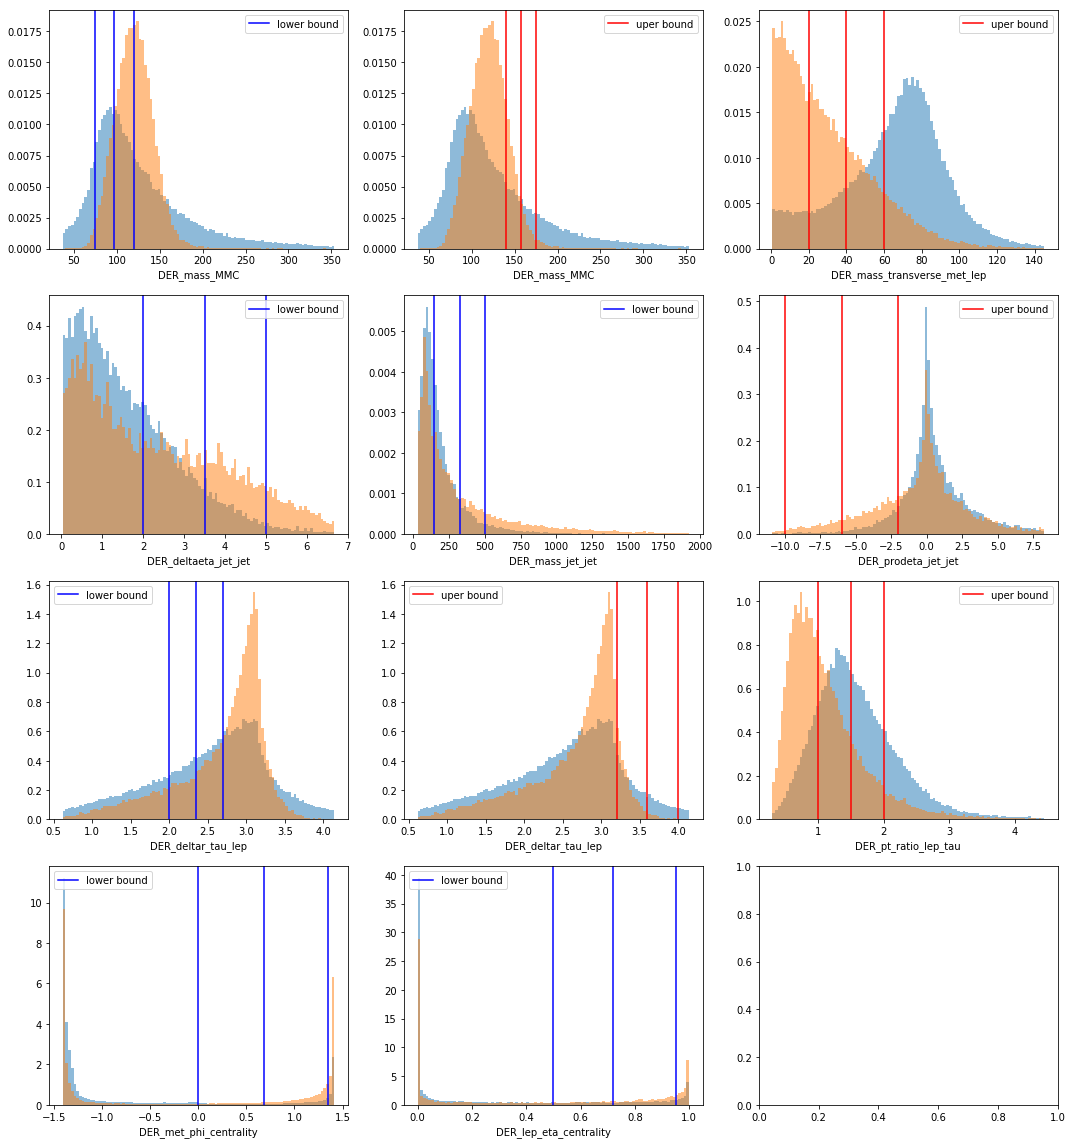

In [9]:
nrows = math.ceil(len(cuts) / 3.)
fig, axs = plt.subplots(figsize=(15, 4 * nrows), nrows=nrows, ncols=3)
for cut, ax in zip(cuts, np.array(axs).ravel()):
    col = cut[0].split()[0]
    plot_var(df, col, df[col] != -999, ax)
    is_lowerbound = ">" in cut[0]
    for v in cut[1]:
        color = "blue" if is_lowerbound else "red"
        line = ax.axvline(v, color=color)
    ax.legend([line], ["lower bound" if is_lowerbound else "uper bound"])
fig.tight_layout()

We will add an extra cut for each variable later that consists of no cut - giving us the possibility to leave out any criterion completely (that's why there is a `+1` in the formula below).

In [10]:
ncomb = np.prod([len(cut[1]) + 1 for cut in cuts])
# 3 arrays (counts, sumw, sumw2) and 8 bytes per number
# furthermore we will scan for signal/background (factor 2)
# and train test (another factor 2)
memory_mib = ncomb * 8 * 3 * 2 * 2/ 1024 / 1024 
print(f"We will scan {ncomb} combinations - might take around {memory_mib} MiB of memory")

We will scan 4194304 combinations - might take around 384.0 MiB of memory


Let's define a function that will give us a cut expression for a given multi_index later. We will define the indices such that the first index of each variable corresponds to no cut at all.

In [11]:
def get_selection(multi_index):
    expr_list = []
    for i, (expr, vals) in zip(multi_index, cuts):
        if i == 0:
            continue
        expr_list.append("({})".format(expr.format(vals[i-1])))
    return expr_list

In [12]:
random_index = np.random.randint(ncuts+1, size=len(cuts))
random_index

array([2, 2, 2, 1, 3, 3, 2, 3, 3, 3, 3])

In [13]:
get_selection(random_index)

['(DER_mass_MMC > 97)',
 '(DER_mass_MMC < 157)',
 '(DER_mass_transverse_met_lep < 40)',
 '(DER_deltaeta_jet_jet > 2.0)',
 '(DER_mass_jet_jet > 500)',
 '(DER_prodeta_jet_jet < -10)',
 '(DER_deltar_tau_lep > 2.35)',
 '(DER_deltar_tau_lep < 3.2)',
 '(DER_pt_ratio_lep_tau < 1.0)',
 '(DER_met_phi_centrality > 1.35)',
 '(DER_lep_eta_centrality > 0.95)']

Now we need to check which events pass each selection. Remember again, we want to define the first selection for each variable such that all events pass. We want to split our dataset into a "training" and "testing" part (50:50). To do so, we add a random selection of 50% each as a first requirement.
Furthermore we want to scan separately for signal and background, so we just add the label as a first cut.

The `masks_list` is a list of 2D arrays of booleans that tell us which event passes which criterion.

In [14]:
random_selection = np.random.rand(len(df)) > 0.5 # for train/test

In [15]:
masks_list = []
masks_list.insert(0, np.array([random_selection, ~random_selection]))
masks_list.insert(1, np.array([(df.Label=="b").values, (df.Label=="s").values]))
for expr, vals in cuts:
    masks = [df.eval(expr.format(val)).values for val in vals]
    pass_all = np.ones(len(df), dtype=np.bool)
    # the first cut matches all combinations
    masks.insert(0, pass_all)
    masks_list.append(np.array(masks, dtype=np.bool))

In [16]:
masks_list

[array([[ True, False,  True, ...,  True,  True, False],
        [False,  True, False, ..., False, False,  True]]),
 array([[False,  True,  True, ...,  True,  True,  True],
        [ True, False, False, ..., False, False, False]]),
 array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        [ True,  True, False, ...,  True, False, False],
        [ True,  True, False, ..., False, False, False]]),
 array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True]]),
 array([[ True,  True,  True, ...,  True,  True,  True],
        [ True, False, False, ...,  True,  True, False],
        [False, False, False, ...,  True,  True, False],
        [False, False, False, ...,  True, False, False]]),
 array([[ True,  True,  True, ...,  True,  True,  True],
        [False, False

Now, let's scan them all using `ahoi`!

In [17]:
counts, sumw, sumw2 = ahoi.scan(masks_list, weights=df.Weight.values)

In [18]:
counts.shape

(2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4)

since we scanned the random selection for train/test as the first selection, signal/background as the second one, we can get the numbers for signal/background/train/test by the following

In [19]:
sumw_train_b = sumw[0][0]
sumw_train_s = sumw[0][1]
sumw_test_b = sumw[1][0]
sumw_test_s = sumw[1][1]

## ROC curve and final metric
Next, we want to fill the ROC curve. To do so we need to decide against which base rate we want to calculate the true and false positive rates.

In [20]:
base_b = df[(df.Label=="b")].Weight.sum()
base_s = df[(df.Label=="s")].Weight.sum()
train_factor = np.count_nonzero(random_selection) / len(df) # we only selected a random subset
base_b_train = base_b * train_factor
base_s_train = base_s * train_factor
fpr_train, tpr_train, roc_ids = ahoi.roc_curve(sumw[0], base_b_train, base_s_train, bins=100)

We can compare to the test set by picking the same combinations (using the `roc_ids` returned by `ahoi.roc_curve`)

In [21]:
test_factor = np.count_nonzero(~random_selection) / len(df)
base_b_test = base_b * test_factor
base_s_test = base_s * test_factor
fpr_test = (sumw_test_b / base_b_test).ravel()[roc_ids]
tpr_test = (sumw_test_s / base_s_test).ravel()[roc_ids]

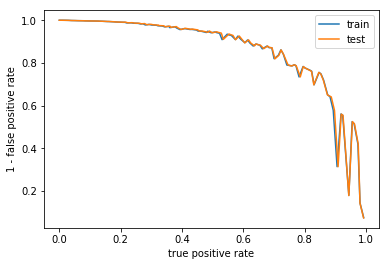

In [22]:
plt.plot(tpr_train, 1 - fpr_train, label="train")
plt.plot(tpr_test, 1 - fpr_test, label="test")
plt.xlabel("true positive rate")
plt.ylabel("1 - false positive rate")
plt.legend()

/home/n/Nikolai.Hartmann/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


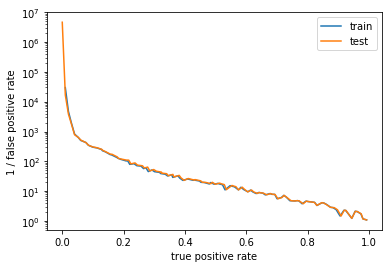

In [23]:
plt.plot(tpr_train, 1. / fpr_train, label="train")
plt.plot(tpr_test, 1. / fpr_test, label="test")
plt.yscale("log")
plt.xlabel("true positive rate")
plt.ylabel("1 / false positive rate")
plt.legend()

Now, scan the approximate median significance (ams) that was the metric to optimize in this challenge

In [24]:
def get_ams(s, b):
    # The number 10, added to the background yield, is a regularization term to decrease the variance of the AMS.
    return np.sqrt(2*((s+b+10)*np.log(1+s/(b+10))-s))

for that we need to get the correctly weighted total rates for signal and background (on the ROC curve). This time we need to scale them up (divide by the factor determined above).

In [25]:
sumw_train_s_roc = sumw_train_s.ravel()[roc_ids] / train_factor
sumw_train_b_roc = sumw_train_b.ravel()[roc_ids] / train_factor
sumw_test_s_roc = sumw_test_s.ravel()[roc_ids] / test_factor
sumw_test_b_roc = sumw_test_b.ravel()[roc_ids] / test_factor

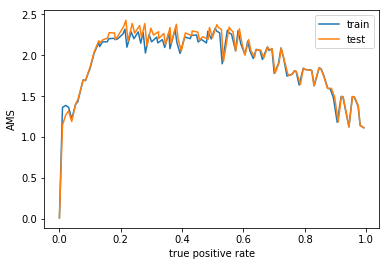

In [26]:
plt.plot(tpr_train, get_ams(sumw_train_s_roc, sumw_train_b_roc), label="train")
plt.plot(tpr_test, get_ams(sumw_test_s_roc, sumw_test_b_roc), label="test")
plt.xlabel("true positive rate")
plt.ylabel("AMS")
plt.legend()

Print the selection for the best AMS value

In [27]:
ams_values = get_ams(sumw_test_s_roc, sumw_test_b_roc)
ams_values.max()

2.4294776376786533

In [28]:
ams_argmax = np.argmax(ams_values)
ams_argmax

21

In [29]:
tpr_test[ams_argmax]

0.21694709734322087

In [30]:
roc_ids[ams_argmax]

3801264

In [31]:
cut_indices = np.unravel_index(roc_ids[ams_argmax], counts.shape)[2:]
cut_indices

(3, 2, 2, 0, 0, 0, 0, 2, 3, 0, 0)

In [32]:
get_selection(cut_indices)

['(DER_mass_MMC > 120)',
 '(DER_mass_MMC < 157)',
 '(DER_mass_transverse_met_lep < 40)',
 '(DER_deltar_tau_lep < 3.6)',
 '(DER_pt_ratio_lep_tau < 1.0)']

We can see, a lot of variables have not been used. It might be worth repeating the scan with less variables and finer granularity!